# WHERE IN TORONTO SHOULD I OPEN MY RESTAURANT?

Guglielmo Sanchini

If folium maps dont display, run the code or look at them in the presentation or in the report.

## Importing

In [1]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis

import json # library to handle JSON files

from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import re # used for regular expressions

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

import seaborn as sns #a beautiful plotting library

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt

# import k-means from clustering stage
from sklearn.cluster import KMeans

# to save and load files
import pickle

# to display a progress bar
from IPython.display import clear_output

import folium # map rendering library

print('Libraries imported.')

Libraries imported.


**These are the credentials I used for Foursquare, which I will obviously hide**

In [2]:
CLIENT_ID = '********' # Foursquare ID
CLIENT_SECRET = '********' # Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET: ' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: ********
CLIENT_SECRET: ********


## Data Preparation, Cleaning and Transformation

**Here I download the list of postal codes of Toronto, the names of Boroughs and Neighbourhoods. 
Then I restrict my analysis to the Boroughs whose name contains "Toronto"**


In [3]:
link = "https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M"
tables = pd.read_html(link,header=0)
df = tables[0]
df.columns = ["PostalCode", "Borough", "Neighbourhood"]
df.head()

,PostalCode,Borough,Neighbourhood
0,M1A,Not assigned,Not assigned
1,M2A,Not assigned,Not assigned
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,Harbourfront


In [4]:
#removing rows where Borough is not assigned
df = df[df.Borough != "Not assigned"].reset_index(drop=True)

#taking care of this special case where NB is NA but Borough exists
df.loc[df[df.Neighbourhood == "Not assigned"].index[0], "Neighbourhood"] = \
df[df.Neighbourhood == "Not assigned"].iloc[0, 1]

#joining with a comma all neighbourhoods realated to a pair (PostalCode, Borough)
df = df.groupby(["PostalCode", "Borough"])["Neighbourhood"].apply(lambda x: ",".join(x)).reset_index()

df.head()

,PostalCode,Borough,Neighbourhood
0,M1B,Scarborough,"Rouge,Malvern"
1,M1C,Scarborough,"Highland Creek,Rouge Hill,Port Union"
2,M1E,Scarborough,"Guildwood,Morningside,West Hill"
3,M1G,Scarborough,Woburn
4,M1H,Scarborough,Cedarbrae


In [5]:
#taking a dataframe which relates postal codes with their coordinates
GC = pd.read_csv("Geospatial_Coordinates.csv")
GC.columns=["PostalCode", "Latitude", "Longitude"]
GC.head()

,PostalCode,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


In [6]:
#joining the dataframes using the column "PostalCode" they have in common
DF = df.join(GC.set_index("PostalCode"), on="PostalCode")
DF.head()

list_neigh_tor = [i for i in range(103) if "Toronto" in DF.Borough[i]]

#restricting DF to only those rows
DF = DF.iloc[list_neigh_tor, :].reset_index(drop=True)
DF.head()

,PostalCode,Borough,Neighbourhood,Latitude,Longitude
0,M4E,East Toronto,The Beaches,43.676357,-79.293031
1,M4K,East Toronto,"The Danforth West,Riverdale",43.679557,-79.352188
2,M4L,East Toronto,"The Beaches West,India Bazaar",43.668999,-79.315572
3,M4M,East Toronto,Studio District,43.659526,-79.340923
4,M4N,Central Toronto,Lawrence Park,43.728020,-79.388790


In [7]:
DF.shape

(38, 5)

**Now for each of the 38 pairs of latitude-longitude correspondence we find (at most)10 restaurants and some related infos, and store this a new dataframe**

In [8]:
# this function takes latitude and longitude as input and executes a query for restaurants within 
# 1000 meters from the input location
# it then puts them into a dataframe and returns it after some cleaning operations

def create_rest_df(latitude, longitude):
    
    LIMIT=10
    search_query = 'Restaurant'
    radius = 1000

    url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&query={}&radius={}&limit={}'. \
    format(CLIENT_ID, CLIENT_SECRET, latitude, longitude, VERSION, search_query, radius, LIMIT)

    results = requests.get(url).json()
    venues = results['response']['venues']

    # tranform venues into a dataframe
    dataframe = json_normalize(venues)
    #dataframe.head()
    filtered_columns = ['name', 'categories'] + [col for col in dataframe.columns if col.startswith('location.')] + ['id']
    dataframe_filtered = dataframe.loc[:, filtered_columns]

    # function that extracts the category of the venue
    def get_category_type(row):
        try:
            categories_list = row['categories']
        except:
            categories_list = row['venue.categories']

        if len(categories_list) == 0:
            return None
        else:
            return categories_list[0]['name']

    # filter the category for each row
    dataframe_filtered['categories'] = dataframe_filtered.apply(get_category_type, axis=1)

    # clean column names by keeping only last term
    dataframe_filtered.columns = [column.split('.')[-1] for column in dataframe_filtered.columns]

#     dataframe_filtered = dataframe_filtered.drop(["cc", "crossStreet", 
#                                                   "formattedAddress", "labeledLatLngs", "state"], 1)

    return dataframe_filtered

In [9]:
# this function takes a dataframe as input and adds the columns of TIPCOUNT, PRICE, NUMBER OF LIKES, RATING AND NUMBER OF PHOTOS
#using as usual the foursquare API
# it returns the new dataframe
def add_columns(dat):
    
    tipc_info = []
    pric = []
    likes = []
    rating = []
    photos = []

    for index in dat.id:
            
            venue_id = index 
            url = 'https://api.foursquare.com/v2/venues/{}?client_id={}&client_secret={}&v={}'.\
            format(venue_id, CLIENT_ID, CLIENT_SECRET, VERSION)
            result = requests.get(url).json()
            #print(result)
            tipc_info.append(result['response']['venue']["stats"]["tipCount"])
            try:
                pric.append(result['response']['venue']["price"]["message"])
            except:
                pric.append("No")
            likes.append(result['response']['venue']["likes"]["count"])
            try:
                rating.append(result['response']['venue']["rating"])
            except:
                rating.append("No")
            photos.append(result['response']['venue']["photos"]["count"])

    dat["TipCount"] = tipc_info
    dat["Price"] = pric
    dat["Likes"] = likes
    dat["Rating"] = rating
    dat["Photos"] = photos
        
            
    
    return dat 

In [10]:
# here we create the dataframe of the restaurants aorund the 38 locations we found previously, and we enrich it with
# other pieces of information using the add_columns function

# df_list = []

# for i in range(len(DF)):
    
#     clear_output(wait=True)
    
#     latitude, longitude = DF.Latitude[i], DF.Longitude[i]
    
#     df = create_rest_df(latitude, longitude)
    
#     #df = add_columns(df)
    
#     df_list.append(df)
    
#     print("PROGRESS: ", np.round(i/(len(DF)-1) *100 ,2),"%")

In [11]:
# TO SAVE

# with open('df_list', 'wb') as f:
#      pickle.dump(df_list, f)

In [12]:
# TO LOAD

with open('df_list', 'rb') as f:
        df_list = pickle.load(f)

In [13]:
# we drop some columns that for some groups of restaurants are all NaNs
for i in range(len(DF)):
    
    try:
        
        df_list[i] = df_list[i].drop(["crossStreet"], 1)
    
    except:
        
        pass
    
    try:
        
        df_list[i] = df_list[i].drop(["neighborhood"], 1)
    
    except:
        
        pass   
    
    try:
        
        df_list[i] = df_list[i].drop(["postalCode"], 1)
    
    except:
        
        pass 

In [14]:
df_fin = pd.concat([df_list[0], df_list[1], df_list[2], df_list[3], df_list[4], df_list[5],
           df_list[6], df_list[7], df_list[8], df_list[9], df_list[10], df_list[11],
           df_list[12], df_list[13], df_list[14], df_list[15], df_list[16], df_list[17],
           df_list[18], df_list[19], df_list[20], df_list[21], df_list[22], df_list[23],
           df_list[24], df_list[25], df_list[26], df_list[27], df_list[28], df_list[29],
           df_list[30], df_list[31], df_list[32], df_list[33], df_list[34], df_list[35],
           df_list[36], df_list[37]]).reset_index(drop=True)

In [15]:
df_fin = df_fin.drop(["cc", "city", "country", "distance", "formattedAddress", "labeledLatLngs", "state"], 1)
df_fin = df_fin.drop_duplicates(keep="first")
df_fin.head()

,name,categories,address,lat,lng,id,TipCount,Price,Likes,Rating,Photos
0,Isabella’s Boutique Restaurant,Japanese Restaurant,2328 Queen St E,43.673767,-79.282703,587bae87286804584acd2a7a,3,Moderate,6,7.7,10
1,Seaspray Restaurant,Asian Restaurant,629 Kingston Rd,43.678888,-79.298167,4dbc53541e72b351caafda72,3,Cheap,2,No,8
2,Kingston Chinese Restaurant,Chinese Restaurant,955 Kingston Road,43.682120,-79.285980,523e2174498e5496ed8739a7,0,Cheap,0,No,0
3,Spiaggia Restaurant,Italian Restaurant,2318 Queen St E,43.673578,-79.283236,4c007bc59cf52d7f9be813e7,1,Moderate,0,No,0
4,Honey Bee Restaurant,Chinese Restaurant,2028 Queen St E.,43.670409,-79.298406,4ae38f3ff964a520ab9621e3,3,Very Expensive,2,No,0


In [16]:
df_fin.shape

(213, 11)

In [17]:
# we substitute "No"s with zeroes
df_fin.Rating = df_fin.Rating.replace("No", "0").astype(float)

In [18]:
# we remove the tow rows related to offices which we are not interested in
df_fin = df_fin[df_fin.categories != "Office"]

In [19]:
df_fin.categories = df_fin.categories.fillna("Restaurant")

## Data Visualization

**We display the restaurants in Toronto we have found**

In [20]:
address = 'Toronto'

geolocator = Nominatim(user_agent="to_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geographical coordinates of Toronto are {}, {}.'.format(latitude, longitude))


venues_map = folium.Map(location=[latitude, longitude], zoom_start=12)
for lat, lng, label in zip(df_fin.lat, df_fin.lng, df_fin.categories):
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        color='blue',
        popup=label,
        fill = True,
        fill_color='blue',
        fill_opacity=0.6
    ).add_to(venues_map)

# display map
venues_map

The geographical coordinates of Toronto are 43.653963, -79.387207.


**Let's see how the features are distribued**

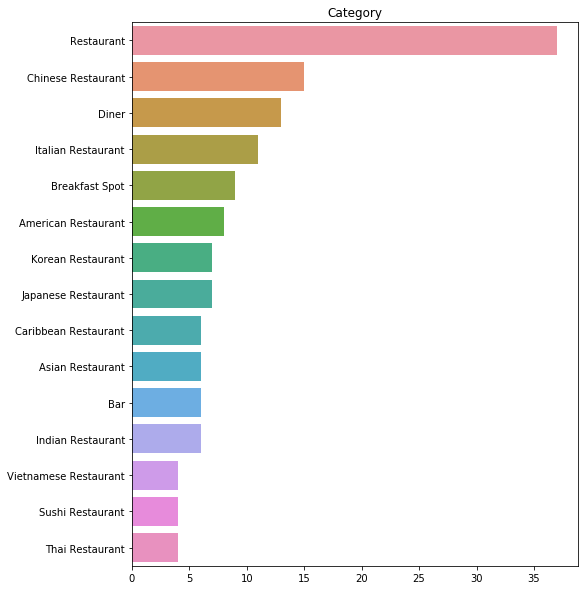

In [21]:
plt.figure(figsize=(8, 10))
sns.countplot(y = "categories", orient='h', order=df_fin.categories.value_counts().iloc[:15].index,
              data = df_fin)
plt.title("Category")
plt.xlabel("")
plt.ylabel("")
plt.show()

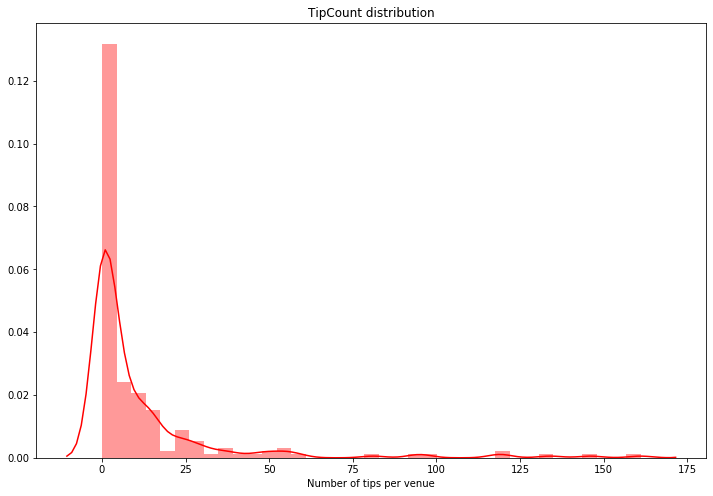

In [22]:
plt.figure(figsize=(12, 8))
sns.distplot(df_fin.TipCount, color="red")
plt.title("TipCount distribution")
plt.xlabel("Number of tips per venue")
plt.show()

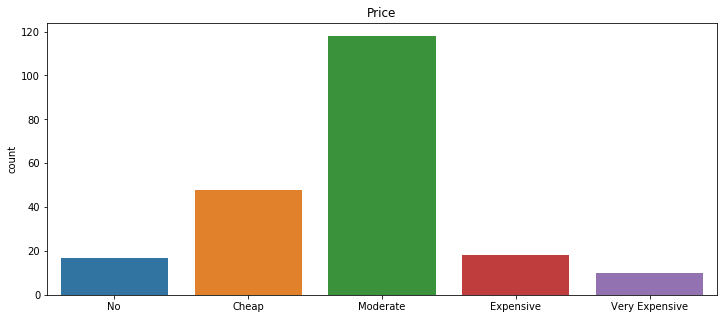

In [23]:
plt.figure(figsize=(12, 5))
sns.countplot(df_fin.Price, order=["No", "Cheap", "Moderate", "Expensive", "Very Expensive"])
plt.title("Price")
plt.xlabel("")
plt.show()

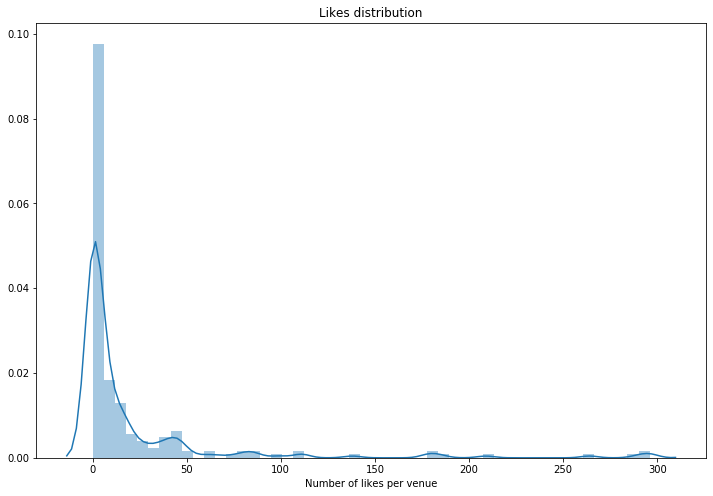

In [24]:
plt.figure(figsize=(12, 8))
sns.distplot(df_fin.Likes)
plt.title("Likes distribution")
plt.xlabel("Number of likes per venue")
plt.show()

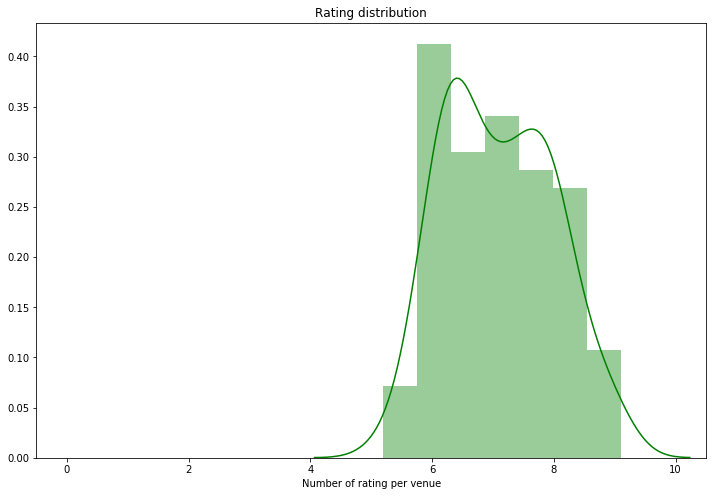

In [25]:
plt.figure(figsize=(12, 8))
sns.distplot(df_fin.Rating[df_fin.Rating != 0], color="g")
plt.title("Rating distribution")
plt.xlabel("Number of rating per venue")
plt.xlim(-0.5,10.5)
plt.show()

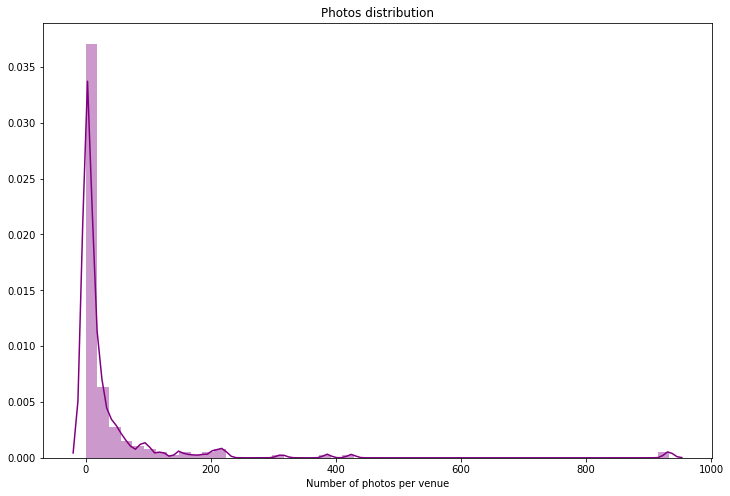

In [26]:
plt.figure(figsize=(12, 8))
sns.distplot(df_fin.Photos, color="purple")
plt.title("Photos distribution")
plt.xlabel("Number of photos per venue")
#plt.xlim(-20,250)
plt.show()

[]

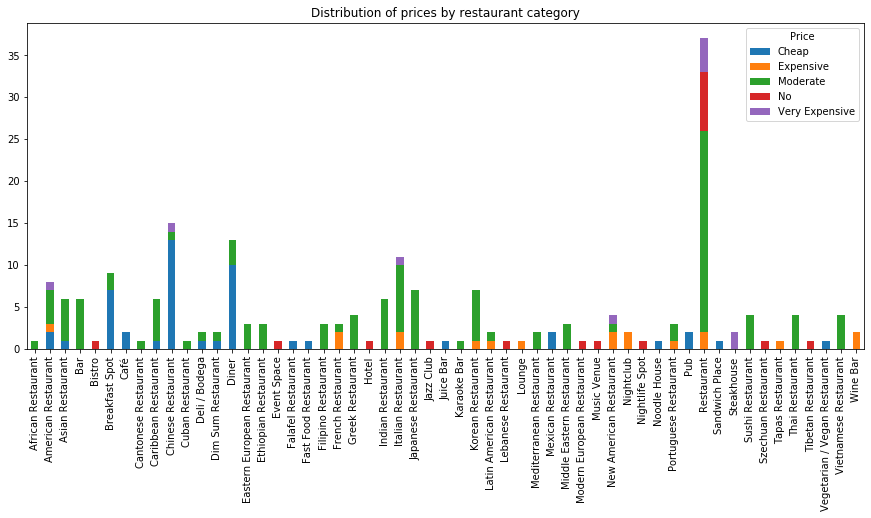

In [27]:
df_plot = df_fin.groupby(['Price', 'categories']).count().reset_index().pivot(columns='Price', index='categories')
df_plot.name.plot.bar(stacked=True, figsize=(15,6))
plt.xlabel("")
plt.title("Distribution of prices by restaurant category")
plt.plot()

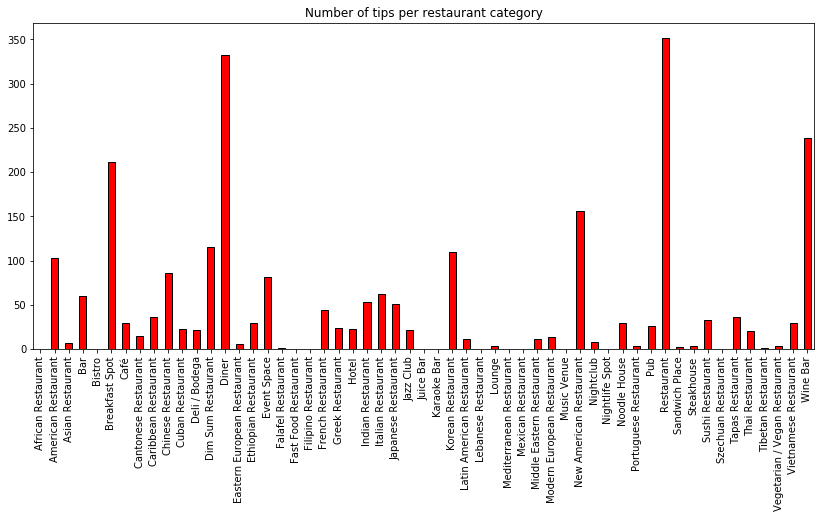

In [28]:
df_fin.groupby("categories")["TipCount"].sum().plot(kind="bar", figsize=(14,6),
                                                    color="red", edgecolor="black")
plt.title("Number of tips per restaurant category")
plt.xlabel("")
plt.show()

## Modeling

In [29]:
df_fin.head()

,name,categories,address,lat,lng,id,TipCount,Price,Likes,Rating,Photos
0,Isabella’s Boutique Restaurant,Japanese Restaurant,2328 Queen St E,43.673767,-79.282703,587bae87286804584acd2a7a,3,Moderate,6,7.7,10
1,Seaspray Restaurant,Asian Restaurant,629 Kingston Rd,43.678888,-79.298167,4dbc53541e72b351caafda72,3,Cheap,2,0.0,8
2,Kingston Chinese Restaurant,Chinese Restaurant,955 Kingston Road,43.682120,-79.285980,523e2174498e5496ed8739a7,0,Cheap,0,0.0,0
3,Spiaggia Restaurant,Italian Restaurant,2318 Queen St E,43.673578,-79.283236,4c007bc59cf52d7f9be813e7,1,Moderate,0,0.0,0
4,Honey Bee Restaurant,Chinese Restaurant,2028 Queen St E.,43.670409,-79.298406,4ae38f3ff964a520ab9621e3,3,Very Expensive,2,0.0,0


In [30]:
# we restrict our dataset to the feautures we use to do the clustering
df_km = df_fin.drop(["name", "address", "lat", "lng", "id"],1)
df_km.head()

,categories,TipCount,Price,Likes,Rating,Photos
0,Japanese Restaurant,3,Moderate,6,7.7,10
1,Asian Restaurant,3,Cheap,2,0.0,8
2,Chinese Restaurant,0,Cheap,0,0.0,0
3,Italian Restaurant,1,Moderate,0,0.0,0
4,Chinese Restaurant,3,Very Expensive,2,0.0,0


In [31]:
#we use label encoder to encode the columns of Price and Category
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df_km["Price"] = le.fit_transform(df_km["Price"])
df_km["categories"] = le.fit_transform(df_km["categories"])

In [32]:
df_km.head()

,categories,TipCount,Price,Likes,Rating,Photos
0,25,3,2,6,7.7,10
1,2,3,0,2,0.0,8
2,9,0,0,0,0.0,0
3,24,1,2,0,0.0,0
4,9,3,4,2,0.0,0


**We use the elbow method and the calinski_harabasz method to individuate the ideal number of clusters**

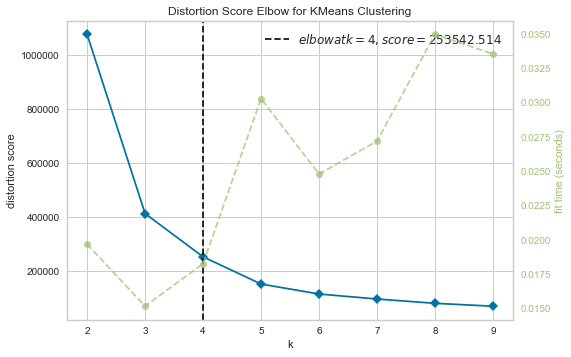

In [34]:
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer
model = KMeans()

visualizer = KElbowVisualizer(model, k=(2,10), timing=False)

visualizer.fit(df_km)        # Fit the data to the visualizer
visualizer.show() 

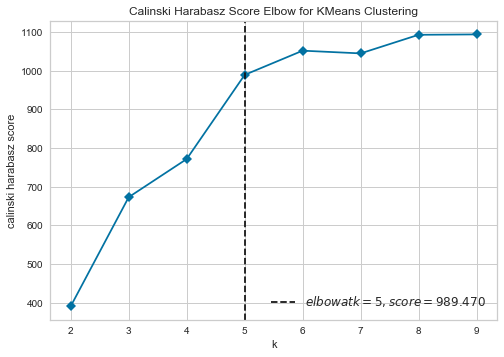

In [35]:
# Instantiate the clustering model and visualizer
model = KMeans()
visualizer = KElbowVisualizer(
    model, k=(2,10), metric='calinski_harabasz', timings=False
)

visualizer.fit(df_km)        # Fit the data to the visualizer
visualizer.show()

In [36]:
# try:
#     df_fin = df_fin.drop("Cluster Labels", 1)
#     print("removed")
# except:
#     print("nothing")

In [37]:
# function that condenses all the  steps to display the folium image for different numbers of K
def Kmeans_folium(num_clusters, df=df_fin):
    # run k-means clustering
    kmeans = KMeans(n_clusters=num_clusters, random_state=42).fit(df_km)

    try:
        df = df.drop("Cluster Labels", 1)
    except:
        pass

    df.insert(0, 'Cluster Labels', kmeans.labels_)
    
    map_clusters = folium.Map(location=[latitude, longitude], zoom_start=12)

    # set color scheme for the clusters
    x = np.arange(num_clusters)
    ys = [i + x + (i*x)**2 for i in range(num_clusters)]
    colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
    rainbow = [colors.rgb2hex(i) for i in colors_array]

    # add markers to the map
    markers_colors = []
    for lat, lon, poi, cluster in zip(df['lat'], df['lng'], df['name'], df['Cluster Labels']):
        label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
        folium.CircleMarker(
            [lat, lon],
            radius=10,
            popup=label,
            color=rainbow[cluster-1],
            fill=True,
            fill_color=rainbow[cluster-1],
            fill_opacity=0.8).add_to(map_clusters)

    return(map_clusters)

In [38]:
#let's see the five clusters on the map
Kmeans_folium(5)

## Cluster explaination

We now characterize the clusters created by the k-means algorithm with the most important features for each of them

**"High Rating" Cluster**

In [39]:
df0 = df_fin.loc[df_fin['Cluster Labels'] == 0, df_fin.columns[[1] +[2] + list(range(7, df_fin.shape[1]))]]
df0.head()

,name,categories,TipCount,Price,Likes,Rating,Photos
30,Gio Rana's Really Really Nice Restaurant,Italian Restaurant,22,Moderate,43,7.4,43
31,The Real Jerk Restaurant,Caribbean Restaurant,16,Moderate,60,8.6,59
57,Alleycatz Live Jazz Bar,Jazz Club,22,No,44,6.6,51
74,Kwan Restaurant,Cantonese Restaurant,15,Moderate,43,7.2,40
84,Cava Restaurant,Tapas Restaurant,36,Expensive,47,8.2,54


In [40]:
df0.describe()

,TipCount,Likes,Rating,Photos
count,27.000000,27.000000,27.000000,27.000000
mean,24.666667,41.222222,7.140741,64.333333
std,10.601161,17.720769,0.902245,23.688686
min,12.000000,11.000000,5.700000,33.000000
25%,16.000000,32.500000,6.400000,47.000000
50%,22.000000,41.000000,7.200000,58.000000
75%,30.000000,47.000000,7.800000,85.500000
max,55.000000,86.000000,8.600000,118.000000


In [41]:
df0.Price.value_counts()

Moderate          11
Cheap              6
Expensive          5
No                 3
Very Expensive     2
Name: Price, dtype: int64

In [42]:
df0.categories.value_counts()[:4]

Restaurant            3
Korean Restaurant     3
Breakfast Spot        2
Dim Sum Restaurant    1
Name: categories, dtype: int64

**"Wine Bar" Cluster, expensive, many likes and many photos**

In [43]:
df1 = df_fin.loc[df_fin['Cluster Labels'] == 1, df_fin.columns[[1] +[2] + list(range(7, df_fin.shape[1]))]]
df1 = df1.drop(170, 0)
df1.head()

,name,categories,TipCount,Price,Likes,Rating,Photos
259,360 Restaurant,Wine Bar,119,Expensive,296,8.0,933


**"High TipCount" Cluster, considerable numbers of likes and photos too**

In [44]:
df2 = df_fin.loc[df_fin['Cluster Labels'] == 2, df_fin.columns[[1] +[2]+  list(range(7, df_fin.shape[1]))]]
df2.head(7)

,name,categories,TipCount,Price,Likes,Rating,Photos
109,Sassafraz | Cafe | Restaurant | Private Events,Event Space,81,No,138,0.0,222
110,ONE Restaurant/Lounge,New American Restaurant,41,Very Expensive,80,7.8,167
119,The Hot House Restaurant & Bar,American Restaurant,56,Moderate,99,7.1,149
128,GEORGE Restaurant,Restaurant,24,Very Expensive,74,8.9,185
134,The Senator Restaurant,Diner,96,Moderate,185,8.0,215
135,Richtree Natural Market Restaurants,Restaurant,49,Moderate,111,6.4,204
160,Rol San Restaurant 龍笙棧,Dim Sum Restaurant,94,Cheap,179,7.3,219


**"Average" Cluster, most numerous one, moderate prices, few tips and pics, low rating generically**

In [45]:
df3 = df_fin.loc[df_fin['Cluster Labels'] == 3, df_fin.columns[[1] +[2]+ list(range(7, df_fin.shape[1]))]]
df3.head()

,name,categories,TipCount,Price,Likes,Rating,Photos
0,Isabella’s Boutique Restaurant,Japanese Restaurant,3,Moderate,6,7.7,10
1,Seaspray Restaurant,Asian Restaurant,3,Cheap,2,0.0,8
2,Kingston Chinese Restaurant,Chinese Restaurant,0,Cheap,0,0.0,0
3,Spiaggia Restaurant,Italian Restaurant,1,Moderate,0,0.0,0
4,Honey Bee Restaurant,Chinese Restaurant,3,Very Expensive,2,0.0,0


In [46]:
df3.describe()

,TipCount,Likes,Rating,Photos
count,169.000000,169.000000,169.000000,169.000000
mean,3.431953,4.526627,2.415385,6.573964
std,5.021067,7.462657,3.344808,9.144776
min,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000
50%,1.000000,1.000000,0.000000,2.000000
75%,5.000000,6.000000,6.300000,11.000000
max,27.000000,45.000000,9.100000,37.000000


In [47]:
df3.Price.value_counts()

Moderate          99
Cheap             40
No                13
Expensive         11
Very Expensive     6
Name: Price, dtype: int64

In [48]:
df3.categories.value_counts()[:4]

Restaurant            30
Chinese Restaurant    13
Diner                 11
Italian Restaurant    10
Name: categories, dtype: int64

**"Top" Cluster, moderate price but high ratings and high numbers of tips and photos**

In [49]:
df4 = df_fin.loc[df_fin['Cluster Labels'] == 4, df_fin.columns[[1] +[2]+ list(range(7, df_fin.shape[1]))]]
df4.head()

,name,categories,TipCount,Price,Likes,Rating,Photos
223,Insomnia Restaurant and Lounge,Restaurant,146,Moderate,290,8.8,313
295,The Lakeview Restaurant,Diner,161,Moderate,264,7.5,386
304,SCHOOL Restaurant,Breakfast Spot,134,Moderate,209,7.8,425


## Conclusions and Tips

So, where would I open my restaurant in Toronto or where would I recommend someone to open a restaurant in Toronto?

Based on the analyses I conducted, here is my answer: it depends?

We have to be a bit more specific in order to give an appropriate answer: if someone wanted to open a restaurant which will likely produce much social engagement and with a well-off target, then he/she should open a Wine Bar, base on what Cluster1 suggests, the location in this case seems not so relevant, since we are considering a single example.

Instead, for a more general recommendation, I would suggest that the restaurant be opened in the western area of Toronto, for example in Dufferin or Lansdowne, where competition is not too high and there is a prevalence of restaurants belonging to the 
Average Cluster, so that the possibily to stand out is high.

